In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
med_charges = pd.read_csv('data/insurance2.csv')

In [3]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


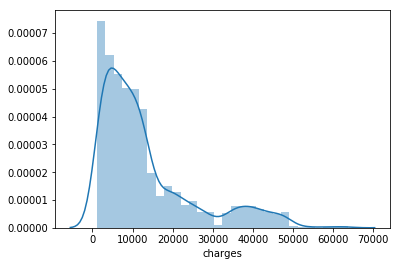

In [4]:
sns.distplot(med_charges.charges)

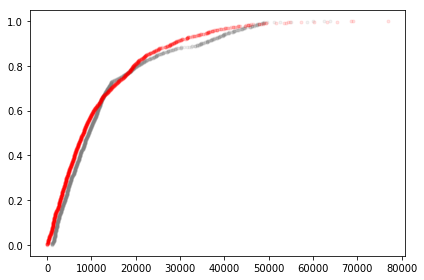

In [5]:
# Function for computing ECDF
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of observations(n) (needs to be a 1d array)
    n = len(data)
    # x-data
    x = np.sort(data)
    # y-data
    y = np.arange(1, n+1) / n
    return x, y

# Compute and plot ECDF from original data
x, y = ecdf(med_charges.charges)
plt.plot(x, y, marker='.', linestyle='none', color='grey', alpha=0.1)

# plot cdf of generated data
gen_charge_data = np.random.exponential(scale=np.std(med_charges.charges),
                                        size=len(med_charges.charges))    # np.random.normal == ss.norm.rvs() 
x, y = ecdf(gen_charge_data)
plt.plot(x, y, marker='.', linestyle='none', color='r', alpha=0.1)
plt.tight_layout()

Bootstrapping reference below

In [6]:
# Single observation (1 charge drawn randomly from sample)
one_random_observation = np.random.choice(med_charges.charges)
print('Single charge drawn from sample data: {}'.format(one_random_observation))

# single bootsrap sample drawn from original data with n = 10
bootstrap_sample = np.random.choice(med_charges.charges, 10)
#print('Single bootstrap sample: {}'.format(bootstrap_sample))

# bootstrap replicate (single value computed from bootstrap sample)
bs_replicate = np.mean(bootstrap_sample)
print('Bootstrap replicate: {}'.format(bs_replicate))

#

Single charge drawn from sample data: 7731.85785
Bootstrap replicate: 18689.769324999997


Below I will use bootstrap sampling and build a sampling distribution of means from our original data. From the distribution I will estimate the lower limit of a 95% confidence interval.

Sampling distribution of means stats:
(red) Mean 13287.69
(red) + 1 std 15727.51
(red) - 1 std 10847.87

Confidence Interval of Sampling Distribution:
(green) Range at 95% confidence level: 8951.56 - 18486.43
    - upper limit (max charge at 97.5th percentile): 18486.43
    - lower limit (min charge at 2.5th percentile): 8951.56


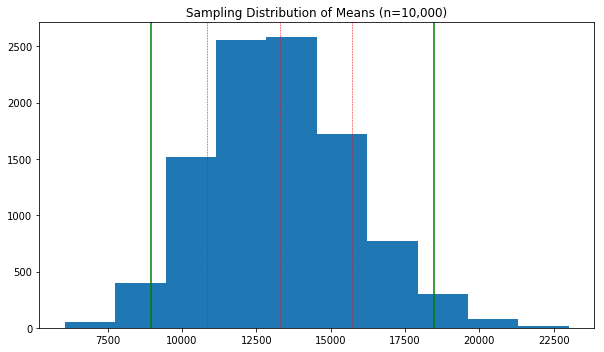

In [8]:
from scipy.stats import norm, t

# Build sampling distribution of the mean from 10,000 boostrap replicates
np.random.seed(47)
N_rep = 10000
n_observations = len(med_charges.charges)
sampdist_ofmeans = [np.mean(np.random.choice(med_charges.charges, n_observations) for _ in range(N_rep)]

# calculate stats for sampling distribution 
sampdist_meancharge = round(np.mean(sampdist_ofmeans),2)
sampdist_std = round(np.std(sampdist_ofmeans, ddof=1),2)
plus_1_std = round(sampdist_meancharge + sampdist_std,2)
minus_1_std = round(sampdist_meancharge - sampdist_std,2)
print('Sampling distribution of means stats:\n(red) Mean {}\n(red) + 1 std {}\n(red) - 1 std {}\n'.format(sampdist_meancharge,
                                                                                                        plus_1_std,
                                                                                                        minus_1_std))

# Establish significance and confidence levels
alpha = 5
conf_level = 1 - alpha

# Minimum charge at lower limit (2.5%) 
min_charge = round(min(sampdist_ofmeans),2)
lower_p = alpha / 2
lower_lim = max(min_charge, np.percentile(sampdist_ofmeans, lower_p))
print('Confidence Interval of Sampling Distribution:')

# Maximum charge at upper limit (97.5%) 
max_charge = round(max(sampdist_ofmeans),2)
upper_p = (100 - alpha) + (alpha / 2)
upper_lim = min(max_charge, np.percentile(sampdist_ofmeans, upper_p))

#calculate confidence interval for Sampling Distribution of means for medical charges
print('(green) Range at 95% confidence level: {} - {}'.format(round(lower_lim,2), round(upper_lim,2)))
print('    - upper limit (max charge at %.1fth percentile): %.2f' % (upper_p, upper_lim))
print('    - lower limit (min charge at %.1fth percentile): %.2f' % (lower_p, lower_lim))

# plot Sampling Distribution of means and display mean and confidence interval range
fig, ax = plt.subplots(1,1, figsize=(8.5, 5))
plt.hist(sampdist_ofmeans)
plt.title('Sampling Distribution of Means (n=10,000)')
plt.axvline(lower_lim, c='g')
plt.axvline(upper_lim, c='g')
plt.axvline(sampdist_meancharge, c='r', ls='--', lw=.5)
plt.axvline(sampdist_meancharge + sampdist_std, c='r', ls='--', lw=.5)
plt.axvline(sampdist_meancharge - sampdist_std, c='r', ls='--', lw=.5)
plt.tight_layout()

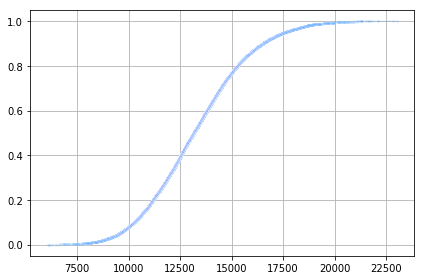

In [9]:
# Compute and plot ECDF from bootstrap sample
x, y = ecdf(sampdist_ofmeans)
sns.lineplot(x, y, marker='.', linestyle='none', color='dodgerblue', alpha=0.1)
plt.grid()
plt.tight_layout()

There are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap approach!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

When to use a Paired Samples T-Test:
>"Use this test if you have one group tested at two different times. In other words, you have two measurements on the same item, person, or thing.The groups are “paired” because there intrinsic connections between them (i.e. they are not independent). This comparison of means is often used for groups of patients before treatment and after treatment, or for students tested before remediation and after remediation. - [statisticshowto.com](https://www.statisticshowto.com/probability-and-statistics/t-test/#PairedTTest)

n observations, (claim-charges) = 783
mean: 16421.358817417626
standard dev: 14533.852946976505


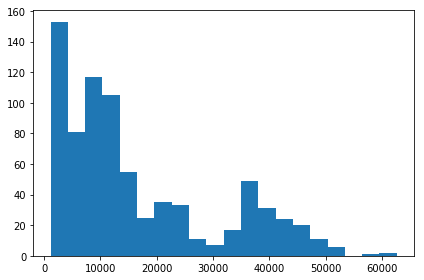

In [44]:
np.random.seed(47)
claim_charges = med_charges.loc[med_charges.insuranceclaim == 1, 'charges']
n_claim = len(claim_charges)
print('n observations, (claim-charges) = {}'.format(len(np.random.choice(claim_charges, n_claim))))
print('mean: {}'.format(np.mean(np.random.choice(claim_charges, n_claim))))
print('standard dev: {}'.format(np.std(np.random.choice(claim_charges, n_claim))))

plt.hist(np.random.choice(claim_charges, n_claim), bins=20)
plt.tight_layout()

In [56]:
np.random.seed(47)
#Sampling Distribution for No-claim charges
noclaim_charges = med_charges.loc[med_charges.insuranceclaim == 0, 'charges']
n_noclaim = len(noclaim_charges)

# sampling dist of mean for no claim charges
noclaim_dist_mean = [np.mean(np.random.choice(noclaim_charges, n_noclaim)) for _ in range(10000)]

# mean of sampling dist of mean for no claim charges
mean_noclaim_dist_mean = round(np.mean(noclaim_dist_mean),2)
print('mean of sampling distribution of mean: {}'.format(mean_noclaim_dist_mean))

# stdandard deviation of sampling dist of mean for no claim charges
std_noclaim_dist_mean = round(np.std(noclaim_dist_mean),2)
print('standard deviation of sampling distribution of mean: {}\n'.format(std_noclaim_dist_mean))
      

# sampling dist of std for no claim charges
noclaim_dist_std = [np.std(np.random.choice(noclaim_charges, n_noclaim)) for _ in range(10000)]

mean_noclaim_dist_std = round(np.mean(noclaim_dist_std),2)
print('mean of sampling distribution of std: {}'.format(mean_noclaim_dist_std))
      
std_noclaim_dist_std = round(np.std(noclaim_dist_std),2)
print('standard deviation of sampling distribution of std: {}'.format(std_noclaim_dist_std))
print('-------------------------------------------------\n')

#Sampling Distribution of means: claim charges
#claim_charges = med_charges.loc[med_charges.insuranceclaim == 1, 'charges']
#n_claim = len(claim_charges)

claim_dist_mean = [np.mean(np.random.choice(claim_charges, n_claim)) for _ in range(10000)]

mean_claim_dist_mean = round(np.mean(claim_dist_mean),2)
print('mean of sampling distribution of mean: {}'.format(mean_claim_dist_mean))

std_claim_dist_mean = round(np.std(claim_dist_mean),2)
print('standard deviation for sampling distribution of mean: {}\n'.format(std_claim_dist_mean))

claim_dist_std = [np.std(np.random.choice(claim_charges, n_claim)) for _ in range(10000)]

mean_claim_dist_std = round(np.mean(claim_dist_std),2)
print('mean for sampling distribution of std: {}'.format(mean_claim_dist_std))

std_claim_dist_std = round(np.std(claim_dist_std),2)
print('standard deviation for sampling distribution of std: {}'.format(std_claim_dist_std))

mean of sampling distribution of mean: 8818.1
standard deviation of sampling distribution of mean: 272.79

mean of sampling distribution of std: 6426.11
standard deviation of sampling distribution of std: 298.77
-------------------------------------------------

mean of sampling distribution of mean: 16426.18
standard deviation for sampling distribution of mean: 501.2

mean for sampling distribution of std: 14021.15
standard deviation for sampling distribution of std: 351.31


Example of Paired:

#FOR INDEPENDANT
#from scipy.stats import ttest_ind
#Calculate the T-test for the means of *two independent* samples of scores
#Signature: ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')

#FOR PAIRED/DEPENDANT
from scipy.stats import ttest_rel

#Paired Sample T-Test: ss.ttest_rel(a=sample1, b=sample2, nan_policy=)

#This is a two-sided test for the null hypothesis,
#that 2 related or repeated samples have identical average (expected) values.
#Returns: (t-statistic, two-sided p value)

np.random.seed(12345678) # fix random seed to get same numbers

rvs1 = norm.rvs(loc=5,scale=10,size=500)

rvs2 = (norm.rvs(loc=5,scale=10,size=500) + norm.rvs(scale=0.2,size=500))
t, p = ttest_rel(rvs1,rvs2)


rvs3 = (norm.rvs(loc=8,scale=10,size=500) + norm.rvs(scale=0.2,size=500))
t_, p_ = ttest_rel(rvs1,rvs3)

print('(blue)   rvs1: mean {}, std {}\n(orange) rvs2: mean {}, std {}\n(green)  rvs3: mean {}, std {}\n'.format(round(np.mean(rvs1),2), round(np.std(rvs1),2),
                                                                                  round(np.mean(rvs2),2), round(np.std(rvs2),2),
                                                                                  round(np.mean(rvs3),2), round(np.std(rvs3),2)))
print('rvs1 and rvs2 t {}, p {}'.format(round(t,2), round(p,2)))
print('rvs1 and rvs3 t {}, p {}'.format(round(t_,2), round(p_,2)))

plt.hist(rvs1, label='rvs1')
plt.show
plt.hist(rvs2, label='rvs2')
plt.show
plt.hist(rvs3, label='rvs3')
plt.legend()
plt.tight_layout()

__A:__

In [ ]:
charges_without_claim = med_charges.loc[med_charges.insuranceclaim == 0, 'charges']
tot_without = len(charges_without_claim)
mean_without = round(np.mean(charges_without_claim),2)
std_without = round(np.std(charges_without_claim, ddof=1),2)
string1 = 'People without claims\n  - Total observations: {}\n  - Average charge: {}\n  - Standard Deviation: {}\n'
print(string1.format(tot_without, mean_without, std_without))

charges_with_claim = med_charges.loc[med_charges.insuranceclaim == 1, 'charges']
tot_with = len(charges_with_claim)
mean_with = round(np.mean(charges_with_claim),2)
std_with = round(np.std(charges_with_claim, ddof=1),2)
string2 = 'People with claims\n  - Total observations: {}\n  - Average charge: {}\n  - Standard Deviation: {}\n'
print(string2.format(tot_with, mean_with, std_with))
print('These averages are only from our sample data...\n\nThe question is then:\nWould these be representative of the entire population?')

In [ ]:
# Build sampling distribution of the mean for charges w/ and w/o claims from 10,000 boostrap replicates
np.random.seed(47)
N_rep = 10000

# sampling distribution of means for charges without claim
without = norm.rvs(loc=mean_without, scale=std_without, size=1338)
sampdist_mean_without = [np.mean(np.random.choice(without, 100)) for _ in range(N_rep)]
# calculate stats for sampling distribution of charges without claims
meanof_sampdist_without = round(np.mean(sampdist_mean_without),2)
stdof_sampdist_without = round(np.std(sampdist_mean_without, ddof=1),2)

# sampling dist of means for charges with claims
with_ = norm.rvs(loc=mean_with, scale=std_with, size=1338)
sampdist_mean_with = [np.mean(np.random.choice(with_, 100)) for _ in range(N_rep)]
# calculate stats for sampling distribution of charges with claims
meanof_sampdist_with = round(np.mean(sampdist_mean_with),2)
stdof_sampdist_with = round(np.std(sampdist_mean_with, ddof=1),2)

t_stat, p_val = ttest_rel(without, with_)
print('T-statistic: {}\nP-Value: {}'.format(t_stat, p_val))

fig, ax = plt.subplots(figsize=(8, 5))
#plt.hist(sampdist_ofmeans, label='sampling distribution means',histtype='step', bins=45)
plt.hist(without, label='charges w/o claims', histtype='stepfilled', bins=20)
plt.axvline(x=np.mean(without), c='blue', ls='--')
plt.hist(with_, label='charges w/ claims', histtype='step', color='r', bins=20)
plt.axvline(x=np.mean(with_), c='r', ls='--')
plt.title('Sampling distribution of means of charges w/ and w/o claims')
plt.legend()
plt.tight_layout()

In [ ]:
np.random.seed(47)
diff = without - with_
mean_difference = round(np.mean(diff),2)
print('Mean Difference: {}'.format(abs(mean_difference)))
std_difference = np.std(diff)
print('Standard deviation of differences: {}'.format(std_difference))
n = len(diff)
standard_error_mean_diff = round(std_difference/np.sqrt(n),2)
print('Standard Error of mean difference: {}'.format(standard_error_mean_diff))
t = mean_difference / standard_error_mean_diff
print('T-value: {}'.format(t))

## __Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates.

In [ ]:
np.random.seed(47)

# For charges without claims
dist_SE_without = norm.rvs(scale=stdof_sampdist_without, size=10000)
print('Standard error of mean (absolute): {}'.format(round(np.mean(abs(dist_SE_without)),2)))
print('Standard error of mean : {}'.format(round(np.mean(dist_SE_without)),2))

# with negative values
plt.hist(dist_SE_without, label='original vals')

# absolute values 
plt.hist(abs(dist_SE_without), histtype='step', label='absolute vals')#, cumulative=True)
plt.title('Distribution of SE for charges w/o claims')
plt.legend()
plt.show()

# For charges with claims
np.random.seed(47)
dist_SE_with = norm.rvs(scale=stdof_sampdist_with, size=10000)
print('Standard error of mean for charges w/ claims (absolute): {}'.format(round(np.mean(abs(dist_SE_with)),2)))
print('Standard error of mean for charges w/ claims : {}'.format(round(np.mean(dist_SE_with)),2))

# with negative values
plt.hist(dist_SE_with, label='original vals')

# absolute values 
plt.hist(abs(dist_SE_with), histtype='step', label='absolute vals')#, cumulative=True)
plt.title('Distribution of SE for charges w/ claims')
plt.legend()
plt.tight_layout()

turd = [np.std(np.random.choice(abs(dist_SE_without), 100), ddof=1) for _ in range(N_rep)]
plt.plot(turd)
plt.plot(dist_SE_without)

In [ ]:
np.random.seed(47)

# without claims 
sampdist_SE_without = [np.mean(np.random.choice(abs(dist_SE_without), 100)) for _ in range(N_rep)]

# plot Sampling distribution of SE of mean
plt.hist(sampdist_SE_without)
plt.title('Sampling distribution of SE of means\n(charges w/o claims)')
plt.show()

# with claims
sampdist_SE_with = [np.mean(np.random.choice(abs(dist_SE_with), 100)) for _ in range(N_rep)]

# plot Sampling distribution of SE of mean
plt.hist(sampdist_SE_with)
plt.title('Sampling distribution of SE of means\n(charges w/ claims)')
plt.tight_layout()

In [ ]:
# calculate stats for sampling distribution of Standard Error of means for charges w/o claims
sampdist_SE_mean = round(np.mean(sampdist_SE_without),2)
sampdist_SE_std = round(np.std(sampdist_SE_without, ddof=1),2)
mean_SE_plus_1sd = round(sampdist_SE_mean + sampdist_SE_std,2)
mean_SE_minus_1_sd = round(sampdist_SE_mean - sampdist_SE_std,2)
samp_distSE_summary = 'Sampling distribution of Standard Error stats:\n(red) Mean SE {}\n(red) + 1 std {}\n(red) - 1 std {}\n'
print(samp_distSE_summary.format(sampdist_SE_mean,mean_SE_plus_1sd,mean_SE_minus_1_sd))

# Establish significance and confidence levels
alpha = 5
conf_level = 1 - alpha

# Minimum charge at lower limit (2.5%) 
min_SE = round(min(sampdist_SE_without),2)
lower_p = alpha / 2
lower_lim = max(min_SE, np.percentile(sampdist_SE_without, lower_p))
print('CI of Sampling Distribution of Standard Deviation for charges w/o claims:\n')

# Maximum charge at upper limit (97.5%) 
max_SE = round(max(sampdist_SE_without),2)
upper_p = (100 - alpha) + (alpha / 2)
upper_lim = min(max_SE, np.percentile(sampdist_SE_without, upper_p))

#calculate confidence interval for Sampling Distribution of means for medical charges
print('(green) CI Range at 95% confidence level: {} - {}'.format(round(lower_lim,2), round(upper_lim,2)))
print('    - upper limit (max charge at %.1fth percentile): %.2f' % (upper_p, upper_lim))
print('    - lower limit (min charge at %.1fth percentile): %.2f' % (lower_p, lower_lim))

Same as above, just now for charges with claims: 

In [ ]:
# calculate stats for sampling distribution of Standard Error of means for charges w/o claims
sampdist_SE_mean1 = round(np.mean(sampdist_SE_with),2)
sampdist_SE_std1 = round(np.std(sampdist_SE_with, ddof=1),2)
mean_SE_plus_1sd1 = round(sampdist_SE_mean1 + sampdist_SE_std1,2)
mean_SE_minus_1_sd1 = round(sampdist_SE_mean1 - sampdist_SE_std1,2)
samp_distSE_summary1 = '(charges w/ claims) Sampling distribution of Standard Error stats:\n(red) Mean SE {}\n(red) + 1 std {}\n(red) - 1 std {}\n'
print(samp_distSE_summary1.format(sampdist_SE_mean,mean_SE_plus_1sd,mean_SE_minus_1_sd))

# Establish significance and confidence levels
alpha = 5
conf_level = 1 - alpha

# Minimum charge at lower limit (2.5%) 
min_SE1 = round(min(sampdist_SE_with),2)
lower_p1 = alpha / 2
lower_lim1 = max(min_SE1, np.percentile(sampdist_SE_with, lower_p1))
print('CI of Sampling Distribution of Standard Deviation for charges w/ claims:\n')

# Maximum charge at upper limit (97.5%) 
max_SE1 = round(max(sampdist_SE_with),2)
upper_p1 = (100 - alpha) + (alpha / 2)
upper_lim1 = min(max_SE1, np.percentile(sampdist_SE_with, upper_p1))

#calculate confidence interval for Sampling Distribution of means for medical charges
print('(green) CI Range at 95% confidence level: {} - {}'.format(round(lower_lim1,2), round(upper_lim1,2)))
print('    - upper limit (max charge at %.1fth percentile): %.2f' % (upper_p1, upper_lim1))
print('    - lower limit (min charge at %.1fth percentile): %.2f' % (lower_p1, lower_lim1))

Plot the histogram of values and mark the locations of the percentiles.

In [ ]:
# (charges w/o claims) plot Sampling Distribution of SE and display mean and confidence interval range
fig, ax = plt.subplots(1,1, figsize=(8.5, 5))
plt.hist(sampdist_SE_without)
plt.title('Sampling Distribution of Standard Error (n=10,000)\n(charges w/o claims)')
plt.axvline(lower_lim, c='g')
plt.axvline(upper_lim, c='g')
plt.axvline(sampdist_SE_mean, c='r', ls='--', lw=.5)
plt.axvline(mean_SE_plus_1sd, c='r', ls='--', lw=.5)
plt.axvline(mean_SE_minus_1_sd, c='r', ls='--', lw=.5)
plt.show()

# (charges w/ claims) plot Sampling Distribution of SE and display mean and confidence interval range
fig, ax = plt.subplots(1,1, figsize=(8.5, 5))
plt.hist(sampdist_SE_with)
plt.title('Sampling Distribution of Standard Error (n=10,000)\n(charges w/ claims)')
plt.axvline(lower_lim1, c='g')
plt.axvline(upper_lim1, c='g')
plt.axvline(sampdist_SE_mean1, c='r', ls='--', lw=.5)
plt.axvline(mean_SE_plus_1sd1, c='r', ls='--', lw=.5)
plt.axvline(mean_SE_minus_1_sd1, c='r', ls='--', lw=.5)
plt.tight_layout()

State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.